# Klusterointi ja assosiaatio

## Tavoitteet
Tavoite tässä prosessissa on optimoida drooneja käyttävän kuljetusyrityksen toimintaa löytämällä optimaalisia sijainteja droonikeskuksille. Yritys haluaa myös suositella asiakkaille tuotteita heidän ostoshistoriansa perusteella, joten datasta halutaan löytää kiinnostavia yhteyksiä eri tuoteryhmien välillä. 

## Datan kuvaus
Käytössä on 2 eri datasettiä: 
- Asiakkaiden sijannit, joka pitää sisällään seuraavat sarakkeet:
    - clientid: Asiakkaan oma tunniste
    - x: Asiakkaan sijainnin x-kordinaatti
    - y: Asiakkaan sijainnin y-kordinaatti
- Tuotteiden myyntidata, joka pitää sisällään seuraavat sarakkeet:
    - ID: Ostotapahtuman tunniste
    - Prod1-Prod20: Binääriarvo, joka kertoo ostettiinko tietystä tuoteryhmästä tuote vai ei arvoilla yksi (1) tai nolla (0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_cust = pd.read_csv('drone_cust_locations.csv', sep=";", na_values=[""], decimal=".", header=0)
df_prod = pd.read_csv('drone_prod_groups.csv', sep=",", na_values=[""], decimal=".")

## Osa 1: Klusterointi

Otetaan pieni näyte datasetin sisällöstä. Datasetti ei ole kovin monimutkainen, joten siinä ei pitäisi löytyä paljoa puuttuvia arvoja.

In [2]:
df_cust.head()

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


### Datan ymmärtäminen
Visualisoidaan asiakkaiden sijainnit:

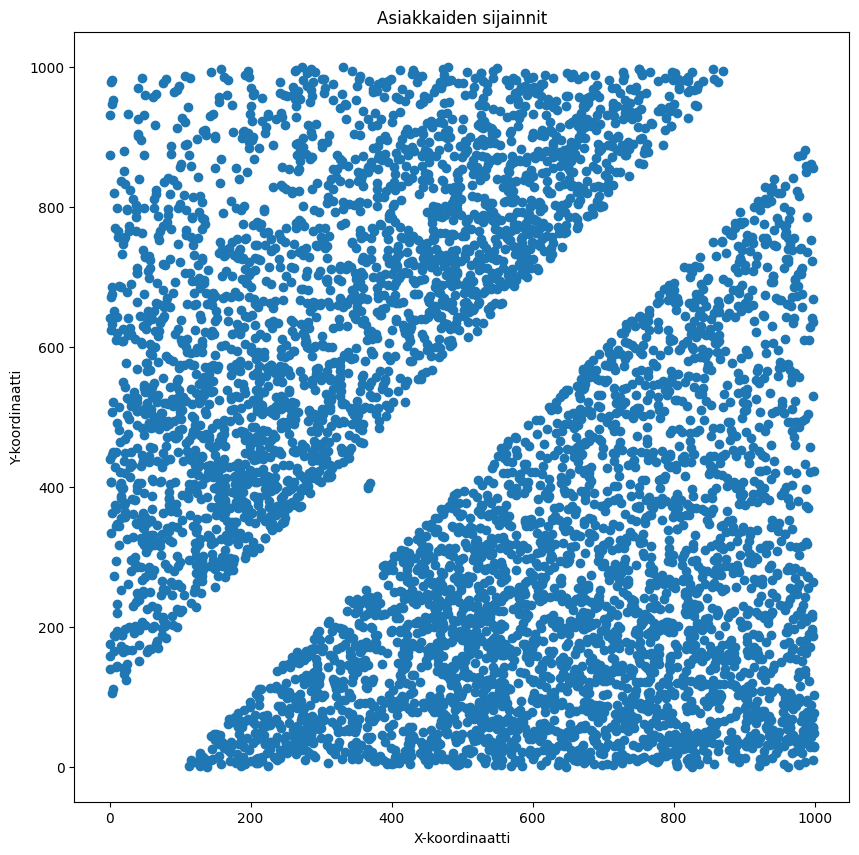

In [3]:
# Create the scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(df_cust['x'], df_cust['y'])
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Graafin perusteella voidaan arvioida, että asiakkaiden sijaintien keskeltä menee iso tie tai joki. Seuraavaksi arvioimme kolme optimaalista sijaintia droonikeskuksille.

### Datan esikäsittely
Dataa ei tarvitse tässä vaiheessa normalisoida, koska tutkimme vain kordinaattiarvoja, jotka ovat jo samassa skaalassa. Poistamme datasetistä turhan ID-sarakkeen.

In [4]:
df_cust = df_cust.drop(columns="clientid")
df_cust.head()

,x,y
0,622.771572,164.857623
1,416.357298,630.193634
2,292.735020,567.333231
3,737.211288,166.225676
4,540.475375,682.912298


### Mallinnus
Nyt teemme KMeans-algoritmitmiä käyttävän mallin ja suoritamme sen asikas-datasetillä.

In [5]:
from sklearn.cluster import KMeans

n = 3
model_k = KMeans(n_clusters=n, random_state=42)
model_k.fit(df_cust)

KMeans(n_clusters=3, random_state=42)

In [6]:
model_k.cluster_centers_

array([[180.89854774, 546.02319994],
       [626.30514798, 179.0966322 ],
       [641.78201689, 758.34167274]])

Näemme yllä muodostuneiden klustereiden keskipisteet.

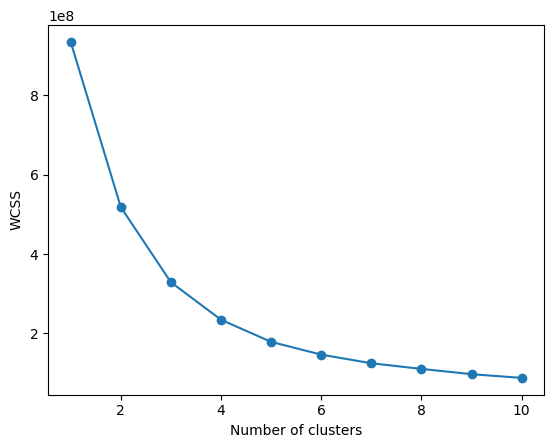

In [7]:
wcss = []
for i in range(1, 11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df_cust)
    wcss.append(model.inertia_)

plt.plot(range(1, 11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Tästä graafista näemme, mikä on optimaalinen määrä klustereita. Tämän datasetin tapauksessa paras määrä näyttää olevan 3, koska 3:n jälkeen WCSS-arvo (within-cluster sum of squared distances) ei laske jyrkästi kuten ennen 3:a.

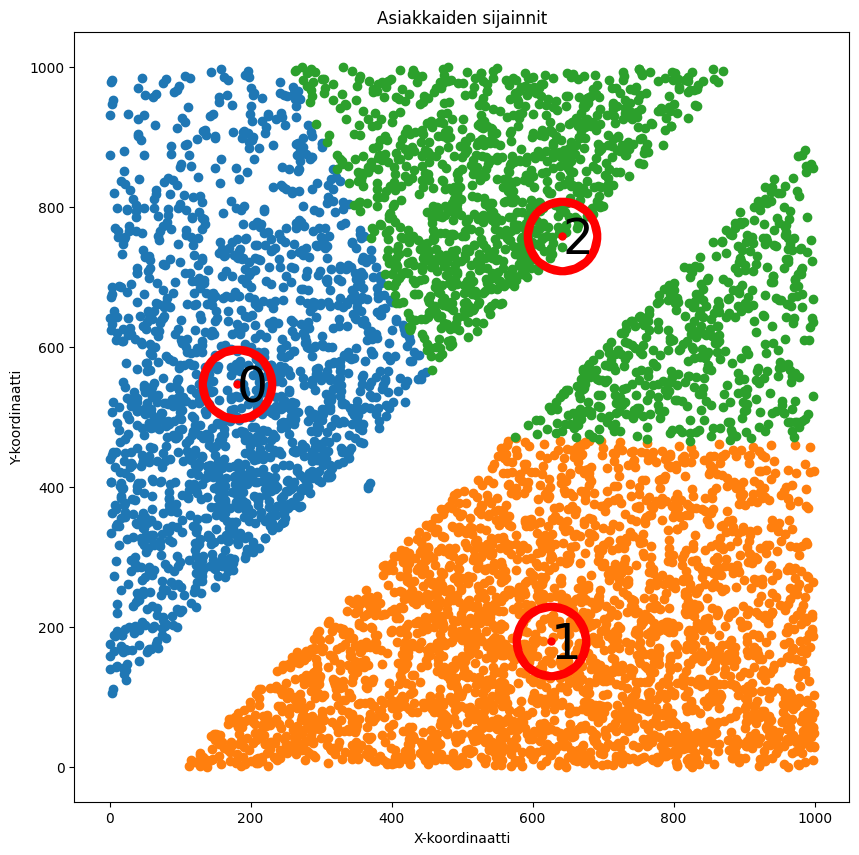

In [8]:
# Create the scatter plot
plt.figure(figsize=(10, 10))
for i in range(n):
    plt.scatter(df_cust['x'][model_k.labels_ == i], df_cust['y'][model_k.labels_ == i])
    plt.text(model_k.cluster_centers_[i][0], model_k.cluster_centers_[i][1] - 25, i, fontsize=35)
plt.scatter(model_k.cluster_centers_[:, 0], model_k.cluster_centers_[:, 1], color="red", linewidths=50)
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Näemme nyt graafista 3:n muodostuneen klusterien keskipisteet, jokaiselle klusterille on annettu myös uniikki tunnusluku. Graafin punaiset pisteet kuvaavat siis droonikeskusten optimaalisia sijainteja. Asiakkaat on myös värikoodattu droonikeskusten mukaan.

In [9]:
from sklearn.metrics import silhouette_score

labels_k = model_k.labels_
print('Silhouette score for model k = %.2f' % silhouette_score(df_cust, labels_k))

Silhouette score for model k = 0.43


Kirjaamme jokaisen mallin jälkeen mallillin siluettiarvon, jotta voimme lopussa verrata mikä malli tuottaa parhaan tuloksen ja millä arvoilla malli sen tuottaa.
Lisätään nyt jokaisen asiakkaan lähin droonikeskus datasettiin.

In [10]:
df_cust_d = df_cust
df_cust_d["d_center"] = model_k.labels_
df_cust_d.head(10)

,x,y,d_center
0,622.771572,164.857623,1
1,416.357298,630.193634,0
2,292.735020,567.333231,0
3,737.211288,166.225676,1
4,540.475375,682.912298,2
5,535.469492,318.439661,1
6,640.380050,870.833221,2
7,235.772075,359.048203,0
8,481.896884,661.491838,2
9,730.032789,312.177817,1


Kokeillaan nyt, minkälaisia tuloksia saamme nostamalla droonikeskusten määrän 10:een.

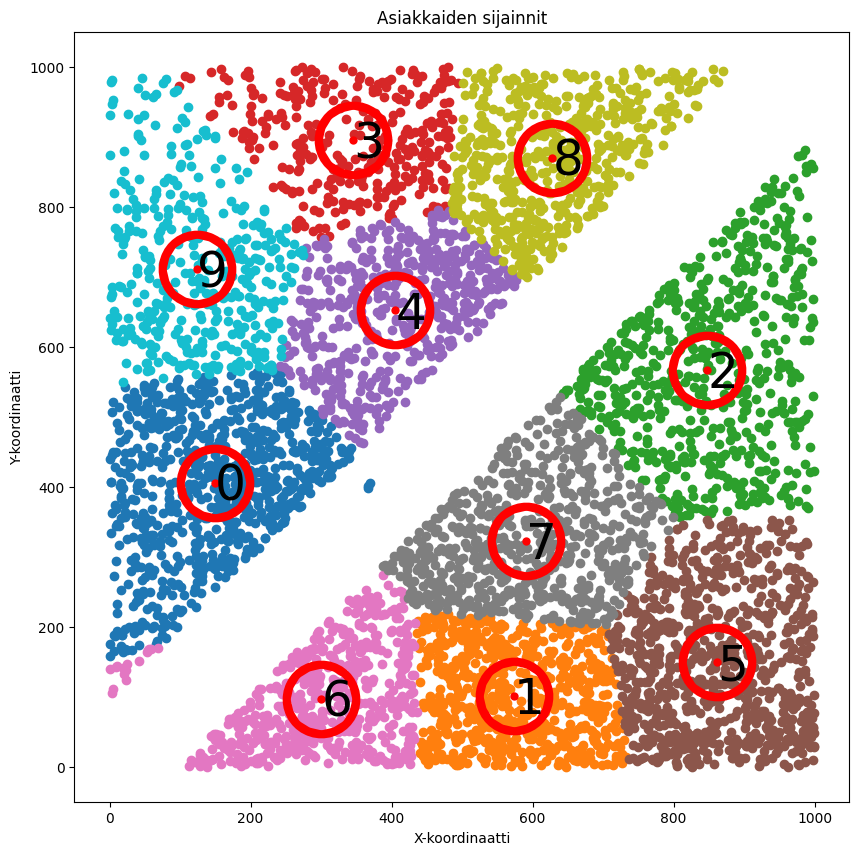

In [11]:
n = 10
model_k = KMeans(n_clusters=n, random_state=42)
model_k.fit(df_cust)

plt.figure(figsize=(10, 10))
for i in range(n):
    plt.scatter(df_cust['x'][model_k.labels_ == i], df_cust['y'][model_k.labels_ == i])
    plt.text(model_k.cluster_centers_[i][0], model_k.cluster_centers_[i][1] - 25, i, fontsize=35)
plt.scatter(model_k.cluster_centers_[:, 0], model_k.cluster_centers_[:, 1], color="red", linewidths=50)
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Graafista löytyy nyt 10 droonikeskusta ja niiden palvelemat asiakkaat. Kun käytettiin arvoa n = 10, mallin ja graafin tekemiseen meni noin kaksinkertainen aika verrattuna n=3 malliin. Kokeillaan nyt mallintaa samaa dataa käyttäen agglomeratiivistä klusterointia. Näemme tässä klusterissa hieman omituisuutta, kun vasemmassa alakulmassa oleva klusteri jakautuu joen molemmille puolille.

In [12]:
labels_k = model_k.labels_
print('Silhouette score for model k = %.2f' % silhouette_score(df_cust, labels_k))

Silhouette score for model k = 0.39


Siluettiarvo laski 0.04:llä verrattuna 3:n klusterin malliin, joten voimme arvioida 3:n klusterin mallin olevan vähän parempi.

Agglomeratiivinen klusterointi lisää enemmän hajontaa klusterien väleille, jos sitä vertaa KMeans-malliin. KMeans-mallin klusteri rajat tuntuvat selviltä ja melkein geometrisen tarkoilta, kun taas agglomeratiivisen klusteroinnin välit sulautuvat toisiinsa paljon enemmän. 

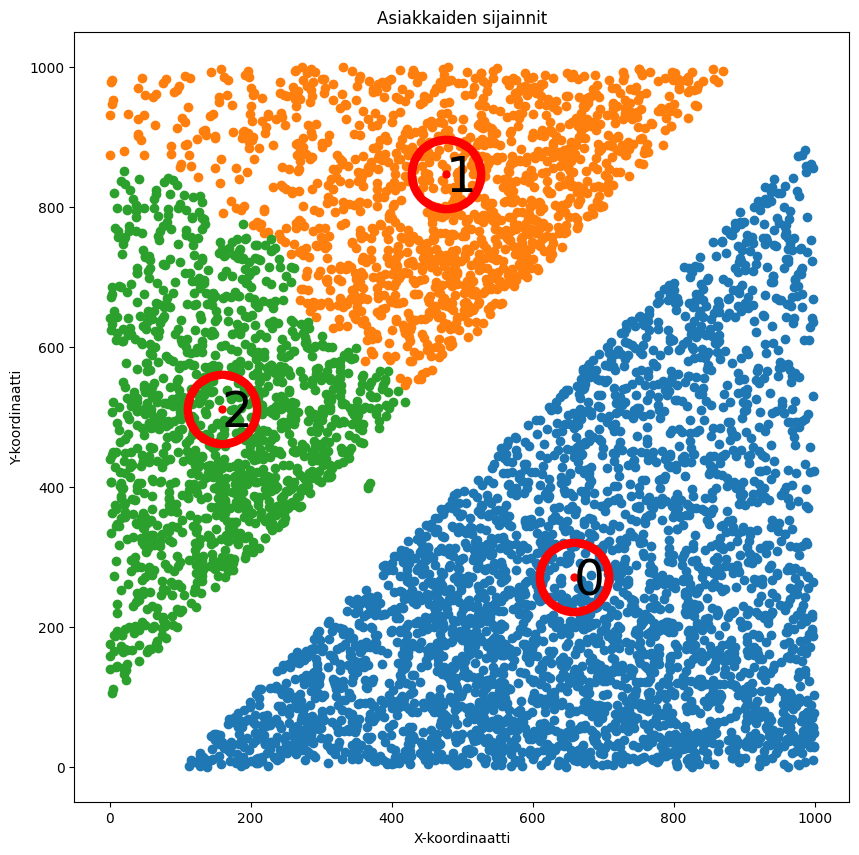

In [13]:
from sklearn.cluster import AgglomerativeClustering

n = 3
model_a = AgglomerativeClustering(n_clusters=n)
model_a.fit(df_cust)

plt.figure(figsize=(10, 10))
for i in range(n):
    plt.scatter(df_cust['x'][model_a.labels_ == i], df_cust['y'][model_a.labels_ == i])

a_centers = np.zeros((n, 2))
for i in range(n):
    x_mean = np.mean(df_cust['x'][model_a.labels_ == i])
    y_mean = np.mean(df_cust['y'][model_a.labels_ == i])
    a_centers[i][0] = x_mean
    a_centers[i][1] = y_mean + 25
    plt.text(x_mean, y_mean, i, fontsize=35)

plt.scatter(a_centers[:, 0], a_centers[:, 1], color="red", linewidths=50)
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

In [14]:
labels_a = model_a.labels_
print('Silhouette score for model k = %.2f' % silhouette_score(df_cust, labels_a))

Silhouette score for model k = 0.40


Siluettiarvo eroaa KMeans-mallin siluettiarvosta 0.03:lla, joten malli K arvolla n=3 vaikuttaa vieläkin olevan paras mahdollinen malli.

Kokeillaan nyt tehdä sama agglomeratiivinen klusteroiniti, mutta tällä kertaa käytämme arvoa n=10.

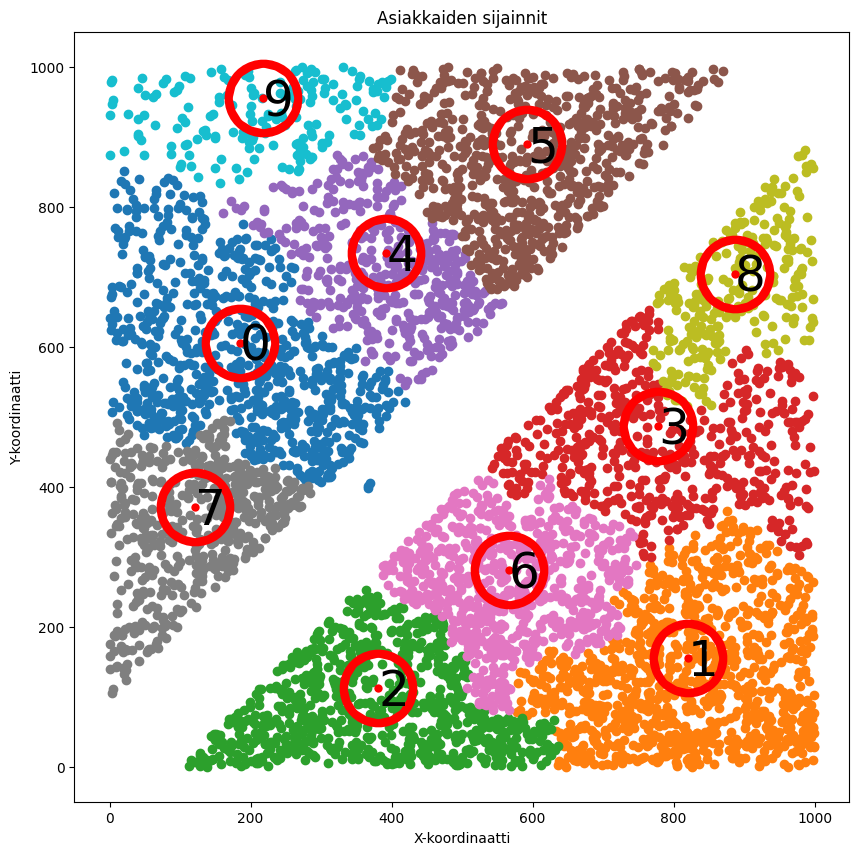

In [15]:
n = 10
model_a = AgglomerativeClustering(n_clusters=n)
model_a.fit(df_cust)

plt.figure(figsize=(10, 10))
for i in range(n):
    plt.scatter(df_cust['x'][model_a.labels_ == i], df_cust['y'][model_a.labels_ == i])

a_centers = np.zeros((n, 2))
for i in range(n):
    x_mean = np.mean(df_cust['x'][model_a.labels_ == i])
    y_mean = np.mean(df_cust['y'][model_a.labels_ == i])
    a_centers[i][0] = x_mean
    a_centers[i][1] = y_mean + 25
    plt.text(x_mean, y_mean, i, fontsize=35)

plt.scatter(a_centers[:, 0], a_centers[:, 1], color="red", linewidths=50)
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

Kun n-arvon nosti 10:een, klusterien määrä kasvoi tietenkin 10:een. Uudet klusterit näyttävät hieman omituisilta, esimerkiksi klusteri 8:n arvoja näyttää olevan hyvin lähellä klusterin 3 kesikpistettä. 

In [16]:
labels_a = model_a.labels_
print('Silhouette score for model k = %.2f' % silhouette_score(df_cust, labels_a))

Silhouette score for model k = 0.33


Siluettiarvo on nyt 0.1 pienempi kuin mallin K(n=3). Voimme määrittää tämän mallin eli malli A(n=10) olevan kaikista malleista huonoin tähän tarkoitukseen.

### Arviointi
Lopputuloksena huomattiin, että KMeans-algoritmiä käyttävä malli eli malli K oli tämän datasetin klusteroimiseen parempi vaihtoehto. Jos tutkii kuvia klusteroinnista, malli K:n klusterit olivat jakautuneet paljon tasaisemmin eikä mallista löytynyt montaa outoa klusterien rajaarvoa. Voidaan myös määritellä, että arvo `n=3` oli kaikista N-arvoista paras. Käyttämällä kyynärpäämetodia voimme päätellä parhaaksi arvoksi 3 tai 4, ja siluettiarvojen perusteella `n=3` arvo oli paljon parempi kuin `n=10`. Joten yhteenvetona paras tulos saadaan käyttämällä mallia K arvolla `n=3`.

## Osa 2: Assosiaatio


### Datan ymmärtäminen
Datasetti pitää sisällään tietoja 20:stä eri tuoteryhmästä, ja 0 tai 1 riippuen siitä, onko asiakas ostanut tuotteen kyseisestä ryhmästä vai ei.

In [17]:
df_prod.head()

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


Tarkastetaan ettei datasetti pidä sisällään NaN-arvoja.

In [18]:
df_prod.describe(include="all")

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,50000.500000,0.109980,0.13098,0.032710,0.035850,0.104590,0.02952,0.134990,0.16179,0.198530,...,0.108480,0.159710,0.013390,0.145570,0.118800,0.131000,0.05618,0.121660,0.206260,0.147980
std,28867.657797,0.312866,0.33738,0.177877,0.185917,0.306026,0.16926,0.341715,0.36826,0.398895,...,0.310987,0.366339,0.114938,0.352676,0.323555,0.337402,0.23027,0.326894,0.404621,0.355082
min,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25000.750000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,50000.500000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,75000.250000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,100000.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


### Datan esikäsittely
Haluamme poistaa turhan `ID` sarakkeen, sekä muuttaa tiedot binääri-muotoon. 

In [19]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df_prod = df_prod.drop(columns="ID")
df_prod = df_prod.apply(lambda x: x.map(lambda y: True if y == 1.0 else False))
df_prod.head()

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True


### Mallinnus
Käytetään apriori-algoritmiä, jotta voimme selvittää yleiset tuotteet ja tuotesetit.

In [20]:
frequent_itemsets = apriori(df_prod, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.20626,( Prod19)


In [21]:
frequent_itemsets = apriori(df_prod, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,(Prod1)
1,0.13098,( Prod2)
2,0.10459,( Prod5)
3,0.13499,( Prod7)
4,0.16179,( Prod8)
5,0.19853,( Prod9)
6,0.10848,( Prod11)
7,0.15971,( Prod12)
8,0.14557,( Prod14)
9,0.11880,( Prod15)


In [22]:
frequent_itemsets = apriori(df_prod, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,(Prod1)
1,0.13098,( Prod2)
2,0.03271,( Prod3)
3,0.03585,( Prod4)
4,0.10459,( Prod5)
...,...,...
165,0.02030,"( Prod20, Prod15, Prod19)"
166,0.02203,"( Prod16, Prod20, Prod19)"
167,0.02052,"( Prod18, Prod20, Prod19)"
168,0.01101,"( Prod5, Prod19, Prod20, Prod12)"


Valitsimme `min_support` arvon `0.01`, koska muut testaamamme arvot eivät tuottaneet tarpeeksi tuloksia. Päätimme myös että `0.01`, eli 1000 ostotapahtumaa, on riittävä minimimäärä tuotteiden välisten yhteyksien löytämiseen.

Seuraavaksi haluamme selvittää yleisten tuoteryhmien välillä löytyvistä säännöistä.

In [23]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules = rules.sort_values(by='confidence', ascending=False)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,"( Prod15, Prod2)",( Prod9),0.01947,0.19853,0.01843,0.946584,4.767967,0.014565,15.004443,0.805959
19,"( Prod15, Prod20)",( Prod9),0.02241,0.19853,0.02119,0.945560,4.762807,0.016741,14.722084,0.808150
29,"( Prod15, Prod19, Prod20)",( Prod9),0.02030,0.19853,0.01919,0.945320,4.761599,0.015160,14.657514,0.806356
14,"( Prod15, Prod12)",( Prod9),0.02308,0.19853,0.02173,0.941508,4.742396,0.017148,13.702169,0.807780
8,"( Prod15, Prod7)",( Prod9),0.02014,0.19853,0.01895,0.940914,4.739403,0.014952,13.564375,0.805220
17,"( Prod18, Prod15)",( Prod9),0.01743,0.19853,0.01640,0.940906,4.739367,0.012940,13.562740,0.802998
18,"( Prod15, Prod19)",( Prod9),0.03041,0.19853,0.02861,0.940809,4.738875,0.022573,13.540390,0.813725
16,"( Prod16, Prod15)",( Prod9),0.01936,0.19853,0.01820,0.940083,4.735217,0.014356,13.376258,0.804389
2,"(Prod1, Prod15)",( Prod9),0.01597,0.19853,0.01501,0.939887,4.734233,0.011839,13.332787,0.801574
0,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,0.087865,12.954372,0.894663


Tämä sääntö kertoo meille mitä tuotetta asiakkaalle kannattaa mainostaa. Esim. Tuotekoreissa (Antecedents) 13 asiakkaalle kannattaisi suositella (Prod9) tuotetta. Sääntö ei kuitenkaan koske vain yhtä tuoteehdotusta vaan monille erilaisille kombinaatioille on jokin paras ehdotus.

### Arviointi
Assosiaatiosääntöjä luodessa `min_threshold` -arvoa olisi voinut muuttaa hieman pienmmäksi, mutta valitsimme arvon `0.7`, koska se karsii paljon tuoteyhdistelmiä sekä antaa korkean todennäköisyyden sille, että antecedents-ryhmän tuotteiden ostamisen seurauksena asiakas ostaa myös consequents-ryhmän tuotteet.

## Käyttöönotto
Droonikeskusten sijainnit voidaan implementoida suoraan yrityksen logistiikkajärjestelmään. Tuoteryhmien väliset yhteydet voidaan integroida yrityksen verkkokauppaan tai mobiilisovellukseen tuotesuositusjärjestelmäksi.Tämä analyysi tarjoaa hyvän pohjan yrityksen toiminnan optimoimiselle, mutta on tärkeää jatkaa datan seurantaa ja päivittää malleja säännöllisesti, kun uutta dataa kertyy.